### RQ 1

#### Read in ARTS datasets

In [1]:
import pickle
import pandas as pd
from matcher import get_mapping_of_LF_and_dims
import math
from scipy import stats
import seaborn as sns
import random
from sklearn.utils import shuffle

resources get initialised


In [2]:
def load_ARTS_data(dims):
    X = []
    scores = []
    labels = []

    if dims == 94:
        path_X = f"/workspace/datasets/ARTS/arts94-1249_labels.pkl"        
        path_y = f"/workspace/datasets/ARTS/Gold_Scores.pkl"          
        path_label = f"/workspace/datasets/ARTS/ARTS_94_DF.pkl"      
    if dims == 300:
        path_X = f"/workspace/datasets/ARTS/arts300-1249_labels.pkl"        
        path_y = f"/workspace/datasets/ARTS/gpt-4-1106-preview-300_scores.pkl"      
        path_label = f"/workspace/datasets/ARTS/ARTS_300_DF.pkl"      
    if dims == 3000:
        path_X = f"/workspace/datasets/ARTS/arts3000-1249_labels.pkl"        
        path_y = f"/workspace/datasets/ARTS/gpt-4-1106-preview-3000_scores.pkl"  
        path_label = f"/workspace/datasets/ARTS/ARTS_3000_DF.pkl"      

    X_labels = pickle.load(open(path_X, "rb"))
    cur_scores = pickle.load(open(path_y, "rb"))
    cur_labels = pickle.load(open(path_label, 'rb'))

    for i, r in cur_labels.iterrows():
        labels.append(r['Label'])

    X = X_labels

    for i in range(len(X)):
        scores.append(cur_scores[i][0])

    return X, scores, labels

In [3]:
arts3000_X, arts3000_scores, arts3000_labels = load_ARTS_data(3000)

#### Prepare structures containing information on relation of parametrizations, interpretations, features, categories

In [4]:
dims_to_names, names_to_dims, names_to_interpretation, names_to_category, name_to_feature = get_mapping_of_LF_and_dims()

In [5]:
names_to_comp_simp = {}

df_cs = pd.DataFrame(arts3000_X)

for dim in range(len(arts3000_X[0])):
    cnts = df_cs[dim].value_counts()

    name = dims_to_names[dim][0]

    if 0 in cnts:
        names_to_comp_simp[name] = 'simp'
    else:
        if 1 in cnts:
            names_to_comp_simp[name] = 'complex'
        else:
            if 'NOT_SIMPLE' in name:
                names_to_comp_simp[name] = 'complex'
            else:
                if 'SIMPLE' in name:
                    names_to_comp_simp[name] = 'simp'
                else:
                    if 'label=1' in name:
                        names_to_comp_simp[name] = 'complex'
                    else:
                        if 'label=0' in name:
                            names_to_comp_simp[name] = 'simp'
                        else:
                            if dim == 228 or dim == 229 or dim == 230 or dim == 555 or dim == 556 or dim == 557 or dim == 558 or dim == 559 or dim == 560 or dim == 561 or dim == 562 or \
                                dim == 563 or dim == 564 or dim == 565 or dim == 566 or dim == 567 or dim == 568 or dim == 569 or dim == 570 or dim == 571 or dim == 571 or dim == 572 or \
                                dim == 573 or dim == 574 or dim == 990:
                                names_to_comp_simp[name] = 'simp'
                            else:
                                if dim == 985 or dim == 991 or dim == 992 or dim == 993 or dim == 994 or dim == 995 or dim == 1001 or dim == 1002 or dim == 1004 or dim == 1005:
                                    names_to_comp_simp[name] = 'complex'
                                else:
                                    print(dim)
                                    print(name)

cnt_feat = {}
cnt_cat = {}

comp_name_to_feature = {}
simp_name_to_feature = {}

for name in name_to_feature:
    feat = name_to_feature[name]
    if names_to_comp_simp[name] == 'simp':
        simp_name_to_feature[name] = feat
    
        if feat + '_simp' not in cnt_feat:
            cnt_feat[feat + '_simp'] = 1
        else:
            cnt_feat[feat + '_simp'] += 1
    else:
        comp_name_to_feature[name] = feat

        if feat + '_complex' not in cnt_feat:
            cnt_feat[feat + '_complex'] = 1
        else:
            cnt_feat[feat + '_complex'] += 1

comp_name_to_cat = {}
simp_name_to_cat = {}

for name in names_to_category:
    cat = names_to_category[name]
    if names_to_comp_simp[name] == 'simp':
        comp_name_to_cat[name] = cat

        if cat + '_simp' not in cnt_cat:
            cnt_cat[cat + '_simp'] = 1
        else:
            cnt_cat[cat + '_simp'] += 1
    else:
        simp_name_to_cat[name] = cat

        if cat + '_complex' not in cnt_cat:
            cnt_cat[cat + '_complex'] = 1
        else:
            cnt_cat[cat + '_complex'] += 1

#### Remap values in X so 1 indicates a characteristic has been encountered and 0 means abstain

In [6]:
def remap(ds):
    arts_X_remapped = []

    for entry in ds:
        vals = []

        for n in entry:
            if n == 0: # simple
                vals.append(1)
            else:
                if n == -1: # abstain 
                    vals.append(0)
                else:
                    if n == 1: # complex
                        vals.append(1)

        arts_X_remapped.append(vals)
        
    return arts_X_remapped

In [7]:
arts3000_X_remapped = remap(arts3000_X)

#### Create structures containing summed up values for dimensions per representarion

In [8]:
dim_to_name_simp = {}
dim_to_name_comp = {}

In [9]:
def split_ds_by_sc(ds):
    para_to_dim_simp = {}
    para_to_dim_comp = {}

    for i in range(len(ds[0])):
        name = dims_to_names[i][0].strip()
        sc = names_to_comp_simp[name]

        if sc == 'simp':
            if not name in para_to_dim_simp:
                dim_to_name_simp[len(para_to_dim_simp)] = name
                para_to_dim_simp[name] = len(para_to_dim_simp)
        else: 
            if not name in para_to_dim_comp:
                dim_to_name_comp[len(para_to_dim_comp)] = name
                para_to_dim_comp[name] = len(para_to_dim_comp)

    all_para_s = []
    all_para_c = []

    for i in range(len(ds)):
        all_para_s.append([0] * len(simp_name_to_feature))
        all_para_c.append([0] * len(comp_name_to_feature))

    # fill structures
    for i in range(len(ds)):
        for j in range(len(ds[i])):
            val = ds[i][j]
            name = dims_to_names[j][0]
            sc = names_to_comp_simp[name]

            if sc == 'simp':
                all_para_s[i][para_to_dim_simp[name]] = val
            else:
                all_para_c[i][para_to_dim_comp[name]] = val
            
    all_para_s = pd.DataFrame(all_para_s)
    all_para_c = pd.DataFrame(all_para_c)

    return all_para_s, all_para_c

In [10]:
all_para_s_3000, all_para_c_3000 = split_ds_by_sc(arts3000_X_remapped)

#### Identify dimensions to be kept (based on "high" correlation of ARTS score and different dimensions from vector representation)

In [11]:
def calc_cors(arts_ds_s, arts_ds_c, scores_ds):
        
    final_cor_s = []

    for i in arts_ds_s.columns:
        cor = stats.pearsonr(arts_ds_s[i], scores_ds)[0]
        if not math.isnan(cor):
            final_cor_s.append((cor, i))
        else:
            final_cor_s.append((0, i))

    final_cor_c = []

    for i in arts_ds_c.columns:
        cor = stats.pearsonr(arts_ds_c[i], scores_ds)[0]
        if not math.isnan(cor):
            final_cor_c.append((cor, i))
        else:
            final_cor_c.append((0, i))
    
    return final_cor_s, final_cor_c

In [12]:
final_cor_s_reduce_3000, final_cor_c_reduce_3000 = calc_cors(all_para_s_3000, all_para_c_3000, arts3000_scores)

kept_names = []
kept_names_s = []
kept_dim_s = []

for tuple in final_cor_s_reduce_3000:
    if tuple[0] <= -0.25:
        kept_dim_s.append(tuple[1])
        kept_names_s.append(dim_to_name_simp[tuple[1]])
        kept_names.append(dim_to_name_simp[tuple[1]])

kept_names_c = []
kept_dim_c = []

for tuple in final_cor_c_reduce_3000:
    if tuple[0] >= 0.25:
        kept_dim_c.append(tuple[1])
        kept_names_c.append(dim_to_name_comp[tuple[1]])
        kept_names.append(dim_to_name_comp[tuple[1]])

/usr/local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


#### Reduce data structures containing correlations to only those where ARTS_3000 had good enough correlation of indication of characteristics with ARTS scores

In [13]:
def reduce_corr_to_kept_dims(final_cor_s, final_cor_c):
    kept_cor_s = []
    for t in final_cor_s:
        if t[1] in kept_dim_s:
            kept_cor_s.append(t[0])

    kept_cor_c = []
    for t in final_cor_c:
        if t[1] in kept_dim_c:
            kept_cor_c.append(t[0])
    
    return kept_cor_s, kept_cor_c

In [14]:
def map_name_to_dim(red_dim_names):
    sim_para_2_dim = {}
    com_para_2_dim = {}
    
    sim_inter_2_dim = {}
    sim_inter = {}
    com_inter_2_dim = {}
    com_inter = {}

    sim_feat_2_dim = {}
    sim_feat = {}
    com_feat_2_dim = {}
    com_feat = {}

    sim_cat_2_dim = {}
    sim_cat = {}
    com_cat_2_dim = {}
    com_cat = {}

    for i in range(len(red_dim_names)):
        name = red_dim_names[i].strip()
        inter = names_to_interpretation[name]
        feat = name_to_feature[name]
        cat = names_to_category[name]

        stance = names_to_comp_simp[name]

        if stance == 'simp':
            sim_para_2_dim[name] = len(sim_para_2_dim)

            if inter in sim_inter:
                sim_inter_2_dim[name] = sim_inter[inter]
            else:
                c_len = len(sim_inter)
                sim_inter_2_dim[name] = c_len
                sim_inter[inter] = c_len
                
            if feat in sim_feat:
                sim_feat_2_dim[name] = sim_feat[feat]
            else:
                c_len = len(sim_feat)
                sim_feat_2_dim[name] = c_len
                sim_feat[feat] = c_len

            if cat in sim_cat:
                sim_cat_2_dim[name] = sim_cat[cat]
            else:
                c_len = len(sim_cat)
                sim_cat_2_dim[name] = c_len
                sim_cat[cat] = c_len
        else:
            com_para_2_dim[name] = len(com_para_2_dim)

            if inter in com_inter:
                com_inter_2_dim[name] = com_inter[inter]
            else:
                c_len = len(com_inter)
                com_inter_2_dim[name] = c_len
                com_inter[inter] = c_len
                
            if feat in com_feat:
                com_feat_2_dim[name] = com_feat[feat]
            else:
                c_len = len(com_feat)
                com_feat_2_dim[name] = c_len
                com_feat[feat] = c_len

            if cat in com_cat:
                com_cat_2_dim[name] = com_cat[cat]
            else:
                c_len = len(com_cat)
                com_cat_2_dim[name] = c_len
                com_cat[cat] = c_len

    return sim_para_2_dim, com_para_2_dim, sim_inter_2_dim, com_inter_2_dim, sim_feat_2_dim, com_feat_2_dim, sim_cat_2_dim, com_cat_2_dim

In [15]:
sim_para_2_dim, com_para_2_dim, sim_inter_2_dim, com_inter_2_dim, sim_feat_2_dim, com_feat_2_dim, sim_cat_2_dim, com_cat_2_dim = map_name_to_dim(kept_names)

In [16]:
def fill_ds_for_datasets(kept_s, kept_c):
    max_inter_s = 0
    max_inter_c = 0

    for e in sim_inter_2_dim:
        if sim_inter_2_dim[e] > max_inter_s:
            max_inter_s = sim_inter_2_dim[e]
    for e in com_inter_2_dim:
        if com_inter_2_dim[e] > max_inter_c:
            max_inter_c = com_inter_2_dim[e]

    max_feat_s = 0
    max_feat_c = 0

    for e in sim_feat_2_dim:
        if sim_feat_2_dim[e] > max_feat_s:
            max_feat_s = sim_feat_2_dim[e]
    for e in com_feat_2_dim:
        if com_feat_2_dim[e] > max_feat_c:
            max_feat_c = com_feat_2_dim[e]

    max_cat_s = 0
    max_cat_c = 0

    for e in sim_cat_2_dim:
        if sim_cat_2_dim[e] > max_cat_s:
            max_cat_s = sim_cat_2_dim[e]
    for e in com_cat_2_dim:
        if com_cat_2_dim[e] > max_cat_c:
            max_cat_c = com_cat_2_dim[e]

    all_int_s = []
    all_int_c = []

    all_feat_s = []
    all_feat_c = []

    all_cat_s = []
    all_cat_c = []
    
    for i in range(max_inter_s + 1):
        all_int_s.append([])
    
    for i in range(max_inter_c + 1):
        all_int_c.append([])

    for i in range(max_feat_s + 1):
        all_feat_s.append([])

    for i in range(max_feat_c + 1):
        all_feat_c.append([])

    for i in range(max_cat_c + 1):
        all_cat_s.append([])
        all_cat_c.append([])

    for i in range(len(kept_s)):
        c_name = kept_names_s[i]
        c_val = kept_s[i]

        c_inter = sim_inter_2_dim[c_name]
        all_int_s[c_inter].append(c_val)
        c_feat = sim_feat_2_dim[c_name]
        all_feat_s[c_feat].append(c_val)
        c_cat = sim_cat_2_dim[c_name]
        all_cat_s[c_cat].append(c_val)


    for i in range(len(kept_c)):
        c_name = kept_names_c[i]
        c_val = kept_c[i]

        c_inter = com_inter_2_dim[c_name]
        all_int_c[c_inter].append(c_val)
        c_feat = com_feat_2_dim[c_name]
        all_feat_c[c_feat].append(c_val)
        c_cat = com_cat_2_dim[c_name]
        all_cat_c[c_cat].append(c_val)

    for j in range((max_inter_s + 1)):
        all_int_s[j] = sum(all_int_s[j])/len(all_int_s[j])

    for j in range((max_inter_c + 1)):
        all_int_c[j] = sum(all_int_c[j])/len(all_int_c[j])

    for j in range((max_feat_s + 1)):
        all_feat_s[j] = sum(all_feat_s[j])/len(all_feat_s[j])

    for j in range((max_feat_c + 1)):
        if len(all_feat_c[j]) > 0:
            all_feat_c[j] = sum(all_feat_c[j]) / len(all_feat_c[j])
        else:
            all_feat_c[j] = 0
            
    for j in range(max_cat_s + 1):
        if '[' in str(all_cat_s[j]):
            all_cat_s[j] = sum(all_cat_s[j])/len(all_cat_s[j])

    for j in range(max_cat_c + 1):

        if '[' in str(all_cat_c[j]):
            all_cat_c[j] = sum(all_cat_c[j]) / len(all_cat_c[j])

    all_para_s = pd.DataFrame(kept_s)
    all_para_c = pd.DataFrame(kept_c)
    all_inter_s = pd.DataFrame(all_int_s)
    all_inter_c = pd.DataFrame(all_int_c)
    all_feat_s = pd.DataFrame(all_feat_s)
    all_feat_c = pd.DataFrame(all_feat_c)
    all_cat_s = pd.DataFrame(all_cat_s)
    all_cat_c = pd.DataFrame(all_cat_c)

    return all_para_s, all_para_c, all_inter_s, all_inter_c, all_feat_s, all_feat_c, all_cat_s, all_cat_c

In [17]:
def splitting_and_remapping(X, kept_names):
    new_X = []
    for i in range(len(X)):
        vals = []

        for j in range(len(X[i])):
            # if dimension is kept in simple/complex dimensions
            if dims_to_names[j][0] in kept_names:
                if X[i][j] == 0: # simple
                    vals.append(1)
                else:
                    if X[i][j] == -1: # abstain 
                        vals.append(0)
                    else:
                        if X[i][j] == 1: # complex
                            vals.append(1)
        new_X.append(vals)
    return new_X

#### Reading in data

In [18]:
def load_data(d_s):
    simp = []
    src = []

    simp_path = f"/workspace/datasets/ds_labels/{d_s}-1249_simp_labels.pkl"        
    src_path = f"/workspace/datasets/ds_labels/{d_s}-1249_src_labels.pkl"  
    
    simp_labels = pickle.load(open(simp_path, "rb"))
    src_labels = pickle.load(open(src_path, "rb")) 

    for entry in simp_labels:
        src.append([number for number in entry.tolist()])

    for entry in src_labels:
        simp.append([number for number in entry.tolist()])
        
    # load textual data
    if d_s == 'EW-SEW-Turk':
        textual_dataset = pd.read_pickle('/workspace/datasets/ewsewturk/ewsewturk.pkl')
    else: 
        if d_s == 'SemEval_2007':    
            textual_dataset = pd.read_pickle('/workspace/datasets/semeval07/semeval07.pkl')
        else:
            if d_s == 'SimpEval_22':
                textual_dataset = pd.read_pickle('/workspace/datasets/simpeval/simpeval.pkl')
            else:
                textual_dataset = pd.read_pickle('/workspace/datasets/' + d_s + '/' + d_s + '.pkl')

    simp_dup = ~textual_dataset['simp'].duplicated()
    src_dup = ~textual_dataset['src'].duplicated()

    dups = simp_dup & src_dup

    data_merged_simp_dedup = []
    data_merged_src_dedup = []

    for index, val in dups.items():
        if val:
            data_merged_simp_dedup.append(simp[index])
            data_merged_src_dedup.append(src[index])

    X = data_merged_simp_dedup + data_merged_src_dedup

    X_sim = splitting_and_remapping(X, kept_names_s)
    X_comp = splitting_and_remapping(X, kept_names_c)

    red_dim_names = []
    for dim in range(len(X_sim[0]) + len(X_comp[0])):
        c_name = dims_to_names[dim][0]

        if c_name in kept_names:              
            red_dim_names.append(c_name)

    return X_sim, X_comp

In [19]:
def load_200_data(datasets):
    all_simp = []
    all_src = []

    for d_s in datasets:    
        simp = []
        src = []
       
        simp_path = f"/workspace/datasets/ds_labels/{d_s}-1249_simp_labels.pkl"        
        src_path = f"/workspace/datasets/ds_labels/{d_s}-1249_src_labels.pkl"  
        
        simp_labels = pickle.load(open(simp_path, "rb"))
        src_labels = pickle.load(open(src_path, "rb"))

        for entry in simp_labels:
            simp.append([number for number in entry.tolist()])

        for entry in src_labels:
            src.append([number for number in entry.tolist()])

        # load textual data
        if d_s == 'EW-SEW-Turk':
            textual_dataset = pd.read_pickle('/workspace/datasets/ewsewturk/ewsewturk.pkl')
        else: 
            if d_s == 'SemEval_2007':    
                textual_dataset = pd.read_pickle('/workspace/datasets/semeval07/semeval07.pkl')
            else:
                if d_s == 'SimpEval_22':
                    textual_dataset = pd.read_pickle('/workspace/datasets/simpeval/simpeval.pkl')
                else:
                    textual_dataset = pd.read_pickle('/workspace/datasets/' + d_s + '/' + d_s + '.pkl')
            
        simp_dup = ~textual_dataset['simp'].duplicated()
        src_dup = ~textual_dataset['src'].duplicated()

        dups = simp_dup & src_dup

        found = 0

        random.seed(42)

        dups = shuffle(dups, random_state=42)


        for index, val in dups.items():
            if val and found < 200:
                found += 1
                all_simp.append(simp[index])
                all_src.append(src[index])

    X = all_simp + all_src

    X_sim = splitting_and_remapping(X, kept_names_s)
    X_comp = splitting_and_remapping(X, kept_names_c)


    return X_sim, X_comp

In [20]:
inter_s_dict = {}

for entry in names_to_interpretation:
    if entry in kept_names_s:
        if not names_to_interpretation[entry] in inter_s_dict:
            inter_s_dict[names_to_interpretation[entry]] = len(inter_s_dict)

inter_c_dict = {}

for entry in names_to_interpretation:
    if entry in kept_names_c:
        if not names_to_interpretation[entry] in inter_c_dict:
            inter_c_dict[names_to_interpretation[entry]] = len(inter_c_dict)

In [21]:
def calc_diff(X, int_copy, k_n, inter_dict):
    half = int(len(X)/2)
    simp = pd.DataFrame(X[:half])
    src = pd.DataFrame(X[half:])

    diffs = int_copy

    for c in simp.columns:
        interp = inter_dict[names_to_interpretation[k_n[c]]]
        diffs[interp].append(abs(sum(simp[c]) - sum(src[c]))/half)

    cur_d = []
    for i in range(len(diffs)):
        cur_d.append(sum(diffs[i])/len(diffs[i]))

    return cur_d

In [22]:
def calc_highest_differences_between_src_simp(ds, is_200_data):
    if is_200_data:
        X_s, X_c = load_200_data(ds)
    else:
        X_s, X_c = load_data(ds)

    interpretations_simple = []
    for i in range(len(inter_s_dict)):
        interpretations_simple.append([])

    interpretations_complex = []
    for i in range(len(inter_c_dict)):
        interpretations_complex.append([])
    
    simp = calc_diff(X_s, interpretations_simple, kept_names_s, inter_s_dict)
    src = calc_diff(X_c, interpretations_complex, kept_names_c, inter_c_dict)

    return simp, src

#### Experiments for Datasets

In [23]:
datasets = ['ASSET', 'AutoMeTS', 'BenchLS', 'britannica', 'EW-SEW-Turk', 'HutSSF', 'metaeval', 'MTurkSF', 'NNSeval', 'OneStopEnglish', 'QuestEval', 'SemEval_2007', 'SimpEval_22', 'simpa', 'TurkCorpus']

simps_ds = []
srcs_ds = []

for ds in datasets:
    a, b = calc_highest_differences_between_src_simp(ds, False)
    simps_ds.append(a)
    srcs_ds.append(b)

<Axes: >

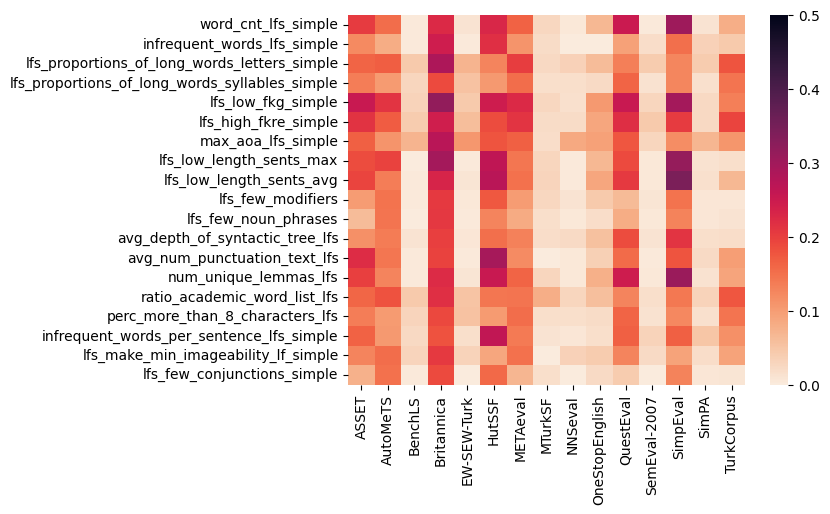

In [24]:
df_ds_s = pd.DataFrame(simps_ds)
df_ds_s = df_ds_s.T
df_ds_s.columns = ['ASSET', 'AutoMeTS', 'BenchLS', 'Britannica', 'EW-SEW-Turk', 'HutSSF', 'METAeval', 'MTurkSF', 'NNSeval', 'OneStopEnglish', 'QuestEval', 'SemEval-2007', 'SimpEval', 'SimPA', 'TurkCorpus']

sns.heatmap(df_ds_s, vmin=0, vmax=0.5, cmap='rocket_r', yticklabels=inter_s_dict.keys())

<Axes: >

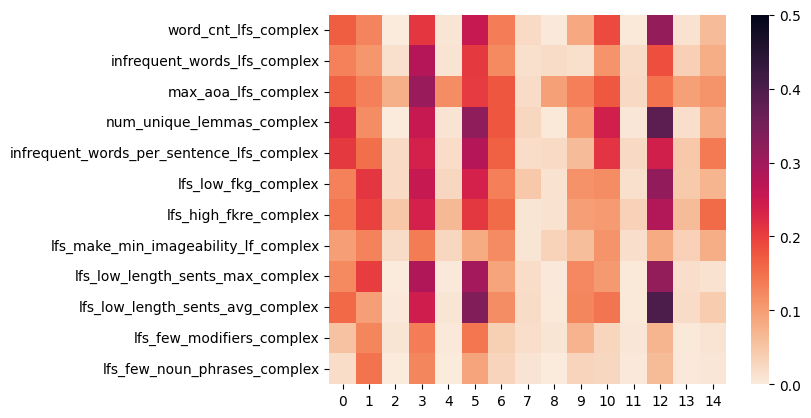

In [25]:
df_ds_c = pd.DataFrame(srcs_ds)
df_ds_c = df_ds_c.T
df_ds_s.columns = ['ASSET', 'AutoMeTS', 'BenchLS', 'Britannica', 'EW-SEW-Turk', 'HutSSF', 'METAeval', 'MTurkSF', 'NNSeval', 'OneStopEnglish', 'QuestEval', 'SemEval-2007', 'SimpEval', 'SimPA', 'TurkCorpus']
sns.heatmap(df_ds_c, vmin=0, vmax=0.5, cmap='rocket_r', yticklabels=inter_c_dict.keys())

#### Experiments for Domains and Target Audiences

In [26]:
datasets = [['britannica', 'TurkCorpus'], ['NNSeval', 'OneStopEnglish', 'simpa', 'TurkCorpus'], ['HutSSF', 'OneStopEnglish'], ['britannica', 'EW-SEW-Turk', 'metaeval', 'NNSeval', 'SimpEval_22', 'TurkCorpus']]
simps_tad = []
srcs_tad = []

for ds in datasets:
    a, b = calc_highest_differences_between_src_simp(ds, True)
    simps_tad.append(a)
    srcs_tad.append(b)

<Axes: >

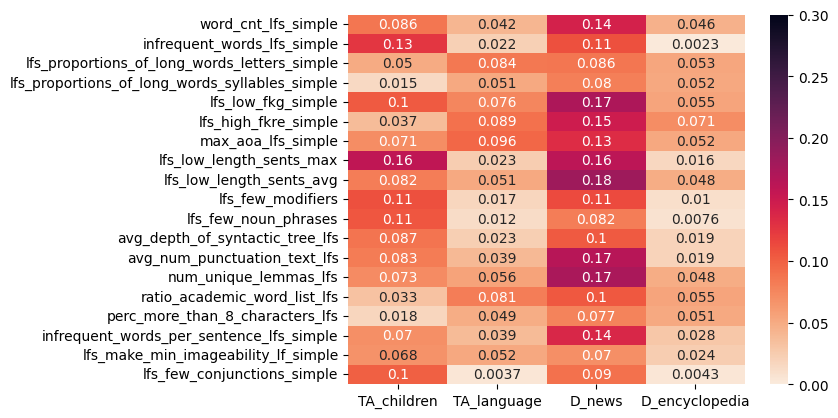

In [27]:
df_tad_s = pd.DataFrame(simps_tad)
df_tad_s = df_tad_s.T
df_tad_s.columns = ['TA_children', 'TA_language', 'D_news', 'D_encyclopedia']
sns.heatmap(df_tad_s, vmin=0, vmax=0.3, cmap='rocket_r', yticklabels=inter_s_dict.keys(), annot=True)

<Axes: >

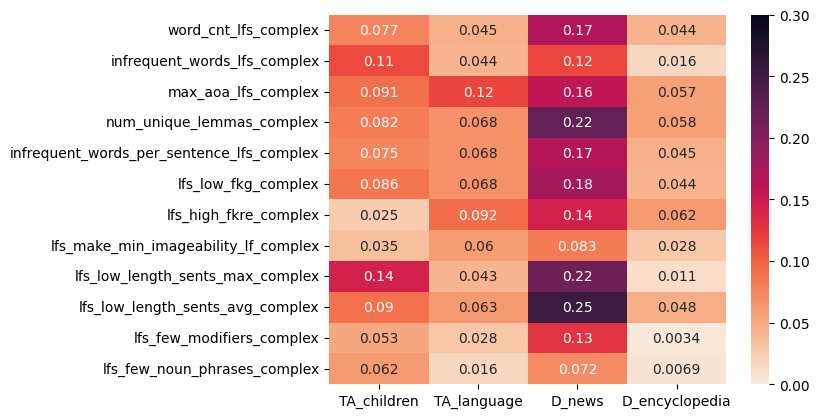

In [28]:
df_tad_c = pd.DataFrame(srcs_tad)
df_tad_c = df_tad_c.T
df_tad_c.columns = ['TA_children', 'TA_language', 'D_news', 'D_encyclopedia']
sns.heatmap(df_tad_c, vmin=0, vmax=0.3, cmap='rocket_r', yticklabels=inter_c_dict.keys(), annot=True)